<a href="https://colab.research.google.com/github/HdemonKhaim/Python_Homeworks/blob/main/ABT12ignatenkov4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [ ]:
def get_bootstrap( #Функция Бутстрапинга
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [ ]:
gett_df = pd.read_csv('new_dataframe.csv')
gett_df.head()

,Unnamed: 0,user_id,hour,os,order_class,surge,app_opened,price_seen,order_made,ride_completed,user_cancelled,city_center_order,distance,age,rfm
0,0,867689,12,iOS,business,no surge,1,1,1,1,0,0,7.982135,20,low
1,1,752172,5,Android,economy,no surge,1,1,1,1,0,1,2.908468,27,high
2,2,486559,15,Android,comfort,no surge,1,1,1,1,0,0,7.224614,21,high
3,3,304024,0,Android,economy,no surge,1,1,1,1,0,1,1.874349,52,low
4,4,139420,0,Android,business,no surge,1,1,1,1,0,0,10.704778,19,low


Первая особенность.Для устройств Android наблюдаем более высокие юзерские отмены

In [ ]:
gett_df_1 = gett_df[['os','user_cancelled']]  #Выбираю нужные столбцы
gett_df_1 = gett_df_1.loc[~gett_df_1['user_cancelled'].isin([0,'NaN'])] #Исключаю столбцы с 0 и пустыми строками
gett_df_1 = gett_df_1.groupby('os').count().reset_index() #Групперую по операционной системе и считаю количество значений в user_cancelled
gett_df_1 = gett_df_1[['os','user_cancelled']] 
gett_df_1.head() #Действительно для устройств Android наблюдаем более высокие юзерские отмены

,os,user_cancelled
0,Android,7353
1,iOS,3916


In [ ]:
gett_df_1_1 = gett_df[['os','order_class','price_seen','user_cancelled']]
gett_df_1_1 = gett_df_1_1.loc[~gett_df_1_1['user_cancelled'].isin([0,'NaN'])]
gett_df_1_1 = gett_df_1_1.loc[gett_df_1_1['os'] != 'iOS'] 
gett_df_1_2 = gett_df_1_1.groupby('order_class').count().reset_index()
gett_df_1_2 = gett_df_1_2[['order_class','user_cancelled']] 
gett_df_1_2.head() #Чаще всего отменяет заказ economy	class

,order_class,user_cancelled
0,business,679
1,comfort,2607
2,economy,4067


**Гипотеза**


---


Если мы увеличим штраф на 25% для пользователей Android эконом-класса, то это уменьшит количество отменненых заказов 8 пп, потому-что пользователи не захотят получить штраф, близкий к стоимости поездки.

In [ ]:
gett_df_android = gett_df[['user_id','order_class','os','user_cancelled']]
gett_df_android = gett_df_android.loc[gett_df_android['os'] != 'iOS']
gett_df_android = gett_df_android.loc[~gett_df_android['order_class'].isin(['comfort','business'])]
gett_df_android['group'] = np.random.randint(2, size=len(gett_df_android)) #Создаю новую группу и присваюваю значения 0 и 1 случайным образом
gett_df_android.loc[(gett_df_android.group == 0), 'Группа'] = 'Группа 1'
gett_df_android.loc[(gett_df_android.group == 1), 'Группа'] = 'Группа 2'
gett_df_android 

,user_id,order_class,os,user_cancelled,group,Группа
1,752172,economy,Android,0,0,Группа 1
3,304024,economy,Android,0,0,Группа 1
11,370093,economy,Android,0,1,Группа 2
12,811050,economy,Android,0,1,Группа 2
16,990097,economy,Android,0,0,Группа 1
...,...,...,...,...,...,...
101473,720593,economy,Android,0,1,Группа 2
101476,887146,economy,Android,1,1,Группа 2
101477,440299,economy,Android,0,1,Группа 2
101487,550292,economy,Android,1,1,Группа 2


In [ ]:
# Посмотрим на количество участников теста.
gett_df_android.groupby('Группа')['Группа'].count()

Группа
Группа 1    13135
Группа 2    13326
Name: Группа, dtype: int64

In [ ]:
gett_df_android.groupby('Группа').agg({'user_cancelled': 'count'})

,user_cancelled
Группа,
Группа 1,13135
Группа 2,13326


In [ ]:
gett_df_android.groupby('Группа').agg({'user_cancelled': 'mean'})

,user_cancelled
Группа,
Группа 1,0.152722
Группа 2,0.154660


(Возьмем α = 0,05)

In [ ]:
mannwhitneyu(gett_df_android[gett_df_android.group == 0].user_cancelled, #Тест Манна-Уитни
             gett_df_android[gett_df_android.group == 1].user_cancelled)

MannwhitneyuResult(statistic=87348865.5, pvalue=0.33101870325623506)

In [ ]:
ttest_ind(gett_df_android[gett_df_android.group == 0].user_cancelled,  #Т-тест
             gett_df_android[gett_df_android.group == 1].user_cancelled)

Ttest_indResult(statistic=-0.4370965658229119, pvalue=0.6620448849334387)

  0%|          | 0/1000 [00:00<?, ?it/s]

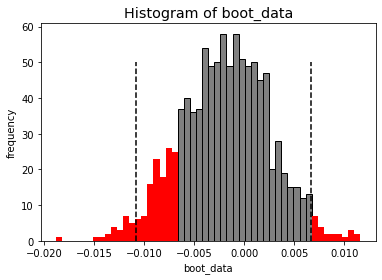

{'boot_data': [0.006828755815698634,
  -0.0006003301815998799,
  -0.004277352543899144,
  0.0028515683625994297,
  0.000375206363499925,
  0.00015008254539996998,
  -0.007053879633798589,
  0.00990544799639802,
  -0.009605282905598079,
  0.0033018159987993397,
  0.011631397268497674,
  -0.0024013207263995197,
  -0.0012006603631997599,
  -0.005402971634398919,
  -0.00030016509079993996,
  -0.007579168542698484,
  0.0015008254539997,
  0.00255140327179949,
  0.0009004952723998199,
  -0.005402971634398919,
  -0.0031517334533993696,
  -0.0066036319975986794,
  -0.0057031367251988594,
  0.0012006603631997599,
  7.504127269998499e-05,
  -0.0011256190904997748,
  -0.0014257841812997149,
  -0.0028515683625994297,
  -0.00765420981539847,
  -0.00870478763319826,
  -0.00075041272699985,
  -0.0027014858171994596,
  -0.004877682725499024,
  -0.007879333633498424,
  -0.006378508179498725,
  0.0015008254539997,
  -0.0015758667266996848,
  -0.0014257841812997149,
  -0.0012006603631997599,
  -0.0058532

In [ ]:
get_bootstrap( #Бутстрапинг
    gett_df_android[gett_df_android.group == 0].user_cancelled, # числовые значения первой выборки
    gett_df_android[gett_df_android.group == 1].user_cancelled, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Результат всех тестов равен p> 0,05. Следовательно, можно считать, что отклонения равны.


Вторая особенность.Если Заказ из центра, то видим более низкие юзерские отмены

In [ ]:
gett_df_2 = gett_df[['city_center_order','user_cancelled']]  #Выбираю нужные столбцы
gett_df_2 = gett_df_2.loc[~gett_df_2['user_cancelled'].isin([0,'NaN'])] #Исключаю столбцы с 0 и пустыми строками
gett_df_2 = gett_df_2.groupby('city_center_order').count().reset_index() #Групперую по заказам из центра и считаю количество значений в user_cancelled
gett_df_2 = gett_df_2[['city_center_order','user_cancelled']] 
gett_df_2.head() #Отмены заказа из центра почти такие же как и отмены не из центра.

,city_center_order,user_cancelled
0,0,5632
1,1,5637


In [ ]:
gett_df_2_1 = gett_df[['order_class','user_cancelled','city_center_order']]
gett_df_2_1 = gett_df_2_1.loc[~gett_df_2_1['user_cancelled'].isin([0,'NaN'])] #Убираю неотмененные поездки
gett_df_2_1 = gett_df_2_1.loc[~gett_df_2_1['city_center_order'].isin([1,'NaN'])] #Убираю заказы из центра города
gett_df_2_2 = gett_df_2_1.groupby('order_class').count().reset_index()
gett_df_2_2 = gett_df_2_2[['order_class','user_cancelled']] 
gett_df_2_2.head() #Чаще всего отменяет заказ economy	class

,order_class,user_cancelled
0,business,507
1,comfort,1987
2,economy,3138


**Гипотеза**


---


Если предоставить пользователям комфорт-класса скидку в 15% при заказе вне центра города, то это уменьшит количество отмененых заказов на 5 пп.

In [ ]:
gett_df_comfort = gett_df[['user_id','order_class','city_center_order','user_cancelled']]
gett_df_comfort = gett_df_comfort.loc[~gett_df_comfort['city_center_order'].isin([1,'NaN'])]
gett_df_comfort = gett_df_comfort.loc[~gett_df_comfort['order_class'].isin(['economy','business'])]
gett_df_comfort['group'] = np.random.randint(2, size=len(gett_df_comfort)) #Создаю новую группу и присваюваю значения 0 и 1 случайным образом
gett_df_comfort.loc[(gett_df_comfort.group == 0), 'Группа'] = 'Группа 1'
gett_df_comfort.loc[(gett_df_comfort.group == 1), 'Группа'] = 'Группа 2'
gett_df_comfort 

,user_id,order_class,city_center_order,user_cancelled,group,Группа
2,486559,comfort,0,0,0,Группа 1
10,464055,comfort,0,0,0,Группа 1
14,382672,comfort,0,0,0,Группа 1
36,580861,comfort,0,0,1,Группа 2
37,109198,comfort,0,0,1,Группа 2
...,...,...,...,...,...,...
101479,112013,comfort,0,0,0,Группа 1
101482,945967,comfort,0,1,0,Группа 1
101488,811817,comfort,0,0,1,Группа 2
101489,969159,comfort,0,0,0,Группа 1


In [ ]:
# Посмотрим на количество участников теста.
gett_df_comfort.groupby('Группа')['Группа'].count()

Группа
Группа 1    8882
Группа 2    9073
Name: Группа, dtype: int64

In [ ]:
gett_df_comfort.groupby('Группа').agg({'user_cancelled': 'mean'})

,user_cancelled
Группа,
Группа 1,0.108309
Группа 2,0.112973


(Возьмем α = 0,05)

In [ ]:
mannwhitneyu(gett_df_comfort[gett_df_comfort.group == 0].user_cancelled, 
             gett_df_comfort[gett_df_comfort.group == 1].user_cancelled)

MannwhitneyuResult(statistic=40105281.0, pvalue=0.1596531575844614)

In [ ]:
ttest_ind(gett_df_comfort[gett_df_comfort.group == 0].user_cancelled, 
             gett_df_comfort[gett_df_comfort.group == 1].user_cancelled)

Ttest_indResult(statistic=-0.9958868235294036, pvalue=0.31931856042019985)

  0%|          | 0/1000 [00:00<?, ?it/s]

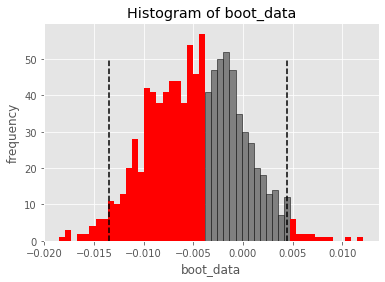

{'boot_data': [0.0005510856387082552,
  0.0007715198941915574,
  0.0007715198941915574,
  -0.007053896175465668,
  -0.002424776810316323,
  -0.005400639259340902,
  -0.0011021712774165104,
  -0.010360410007715199,
  0.0009919541496748595,
  -0.006392593409015761,
  -0.002314559682574672,
  -0.0028656453212829273,
  -0.009699107241265293,
  -0.005069987876115949,
  -0.004629119365149344,
  -0.013005621073514825,
  -0.007494764686432271,
  -0.007274330430948969,
  -0.004629119365149344,
  -0.0005510856387082552,
  -0.005290422131599251,
  -0.005621073514824204,
  -0.0005510856387082552,
  -0.0013226055328998127,
  -0.006723244792240715,
  -0.007715198941915574,
  -0.001763474043866417,
  -0.016532569161247658,
  -0.007825416069657224,
  -0.010139975752231897,
  -0.006392593409015761,
  -0.010139975752231897,
  -0.00837650170836548,
  -0.008817370219332083,
  -0.011352364157390058,
  -0.0034167309599911827,
  0.0014328226606414637,
  -0.005731290642565855,
  -0.006061942025790808,
  -0.00

In [ ]:
get_bootstrap(
    gett_df_comfort[gett_df_comfort.group == 0].user_cancelled, # числовые значения первой выборки
    gett_df_comfort[gett_df_comfort.group == 1].user_cancelled, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
)

Результат всех тестов равен p> 0,05. Следовательно, можно считать, что отклонения равны.
